In [1]:
!pip install -q imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE


In [3]:
df = pd.read_csv('/content/creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
print("Shape of dataset:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Target class distribution:\n", df['Class'].value_counts())


Shape of dataset: (7973, 31)
Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
Target class distribution:
 Class
0.0    7947
1.0      25
Name: count, dtype: int64


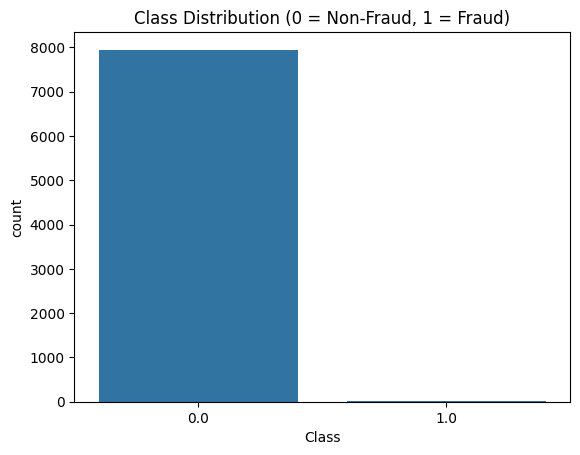

In [5]:
#Exploratory Data Analysis (EDA)
#1. Class Imbalance
sns.countplot(data=df, x='Class')
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()


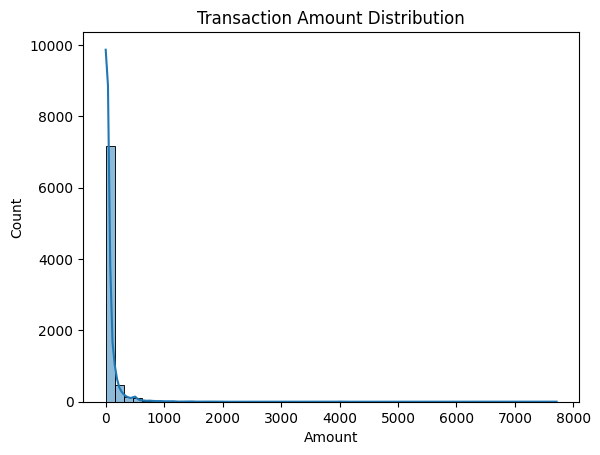

In [6]:
 #2. Distribution of Transaction Amount
 sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


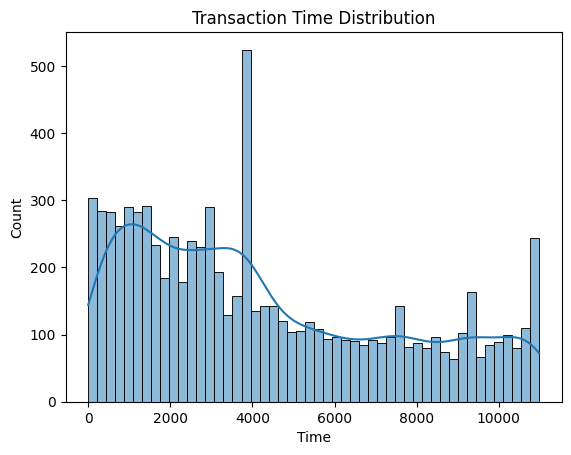

In [7]:
# 3. Distribution of Time
sns.histplot(df['Time'], bins=50, kde=True)
plt.title("Transaction Time Distribution")
plt.show()


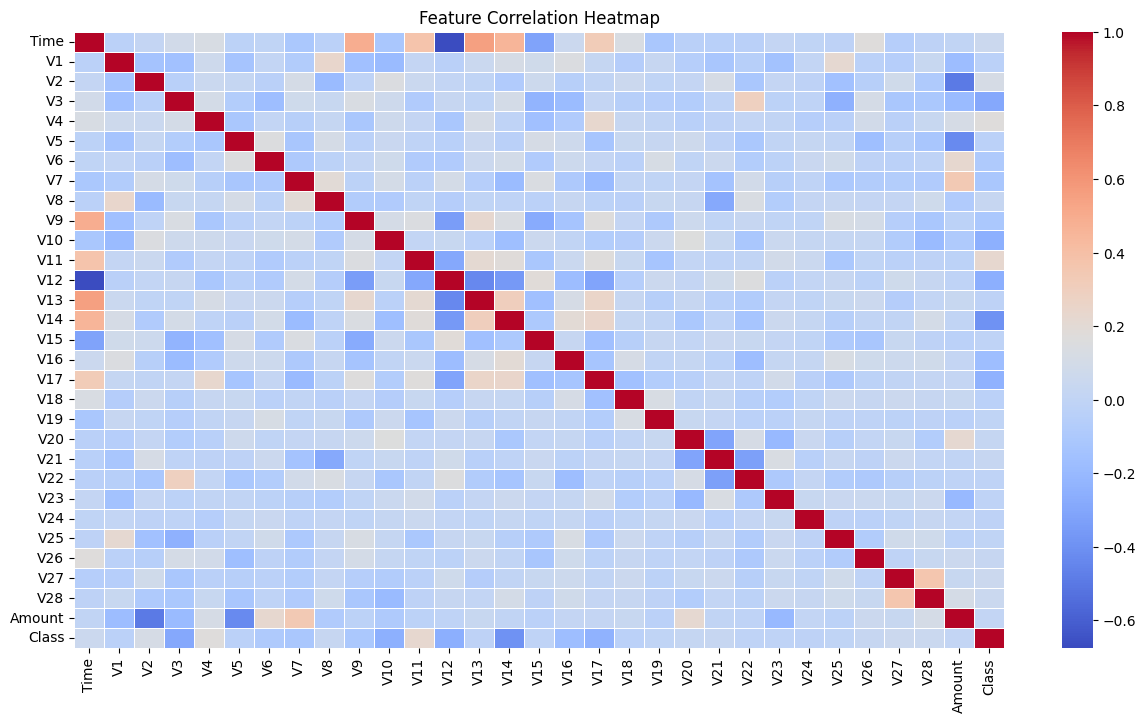

In [8]:
# 4. Correlation Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


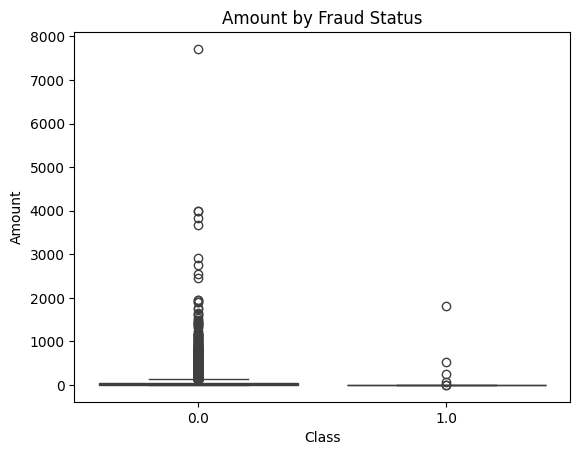

In [9]:
#5. Boxplot for Amount by Class
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Amount by Fraud Status")
plt.show()


In [10]:
#Outlier Detection & Removal using IQR
def remove_outliers_iqr_safe(df, column):
    # Only apply IQR on Class == 0 (genuine) data
    non_fraud = df[df['Class'] == 0]
    fraud = df[df['Class'] == 1]

    Q1 = non_fraud[column].quantile(0.25)
    Q3 = non_fraud[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    non_fraud_clean = non_fraud[(non_fraud[column] >= lower) & (non_fraud[column] <= upper)]
    return pd.concat([non_fraud_clean, fraud], axis=0).sort_index()


In [11]:
df_clean = remove_outliers_iqr_safe(df, 'Amount')
df_clean = remove_outliers_iqr_safe(df_clean, 'Time')

print("Class counts after safe outlier removal:\n", df_clean['Class'].value_counts())


Class counts after safe outlier removal:
 Class
0.0    6998
1.0      25
Name: count, dtype: int64


In [12]:
print("Fraud count:", df_clean['Class'].value_counts())

Fraud count: Class
0.0    6998
1.0      25
Name: count, dtype: int64


In [13]:
# Re-define the safe outlier removal function
def remove_outliers_iqr_safe(df, column):
    non_fraud = df[df['Class'] == 0]
    fraud = df[df['Class'] == 1]

    Q1 = non_fraud[column].quantile(0.25)
    Q3 = non_fraud[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    non_fraud_clean = non_fraud[(non_fraud[column] >= lower) & (non_fraud[column] <= upper)]
    return pd.concat([non_fraud_clean, fraud], axis=0).sort_index()

# Apply to Amount and Time
df_clean = remove_outliers_iqr_safe(df, 'Amount')
df_clean = remove_outliers_iqr_safe(df_clean, 'Time')

print("After safe outlier removal:\n", df_clean['Class'].value_counts())


After safe outlier removal:
 Class
0.0    6998
1.0      25
Name: count, dtype: int64


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_clean[['Amount', 'Time']] = scaler.fit_transform(df_clean[['Amount', 'Time']])


In [15]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("Class", axis=1)
y = df_clean["Class"]

# Keep stratify to maintain class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)

print(" Training class distribution:\n", y_train.value_counts())
print(" Testing class distribution:\n", y_test.value_counts())


 Training class distribution:
 Class
0.0    4899
1.0      17
Name: count, dtype: int64
 Testing class distribution:
 Class
0.0    2099
1.0       8
Name: count, dtype: int64


In [16]:
!pip install -q xgboost


In [17]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(" Random Forest Results:\n")
print(classification_report(y_test, y_pred_rf))

# 2. XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(" XGBoost Results:\n")
print(classification_report(y_test, y_pred_xgb))


 Random Forest Results:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2099
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00      2107
   macro avg       1.00      1.00      1.00      2107
weighted avg       1.00      1.00      1.00      2107

 XGBoost Results:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2099
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00      2107
   macro avg       1.00      1.00      1.00      2107
weighted avg       1.00      1.00      1.00      2107



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:21:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


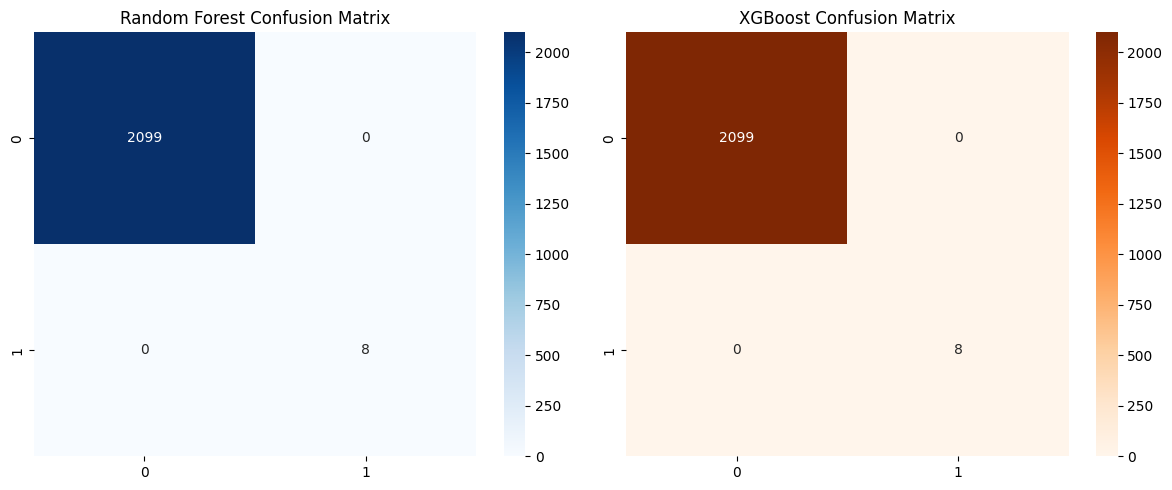

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", ax=ax[0], cmap="Blues")
ax[0].set_title("Random Forest Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", ax=ax[1], cmap="Oranges")
ax[1].set_title("XGBoost Confusion Matrix")

plt.tight_layout()
plt.show()


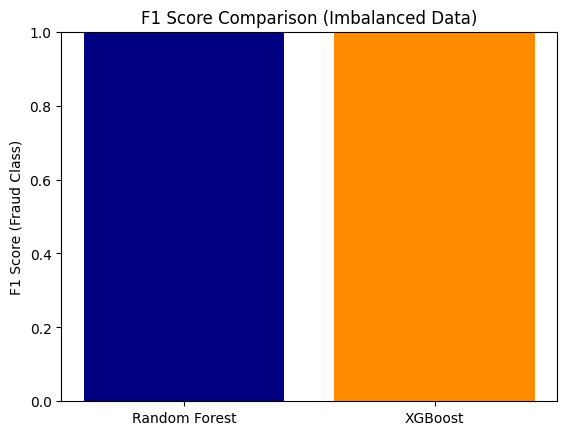

In [19]:
#F1 Score Comparison
from sklearn.metrics import f1_score

f1_rf = f1_score(y_test, y_pred_rf)
f1_xgb = f1_score(y_test, y_pred_xgb)

models = ['Random Forest', 'XGBoost']
scores = [f1_rf, f1_xgb]

plt.bar(models, scores, color=['navy', 'darkorange'])
plt.title("F1 Score Comparison (Imbalanced Data)")
plt.ylabel("F1 Score (Fraud Class)")
plt.ylim(0, 1)
plt.show()


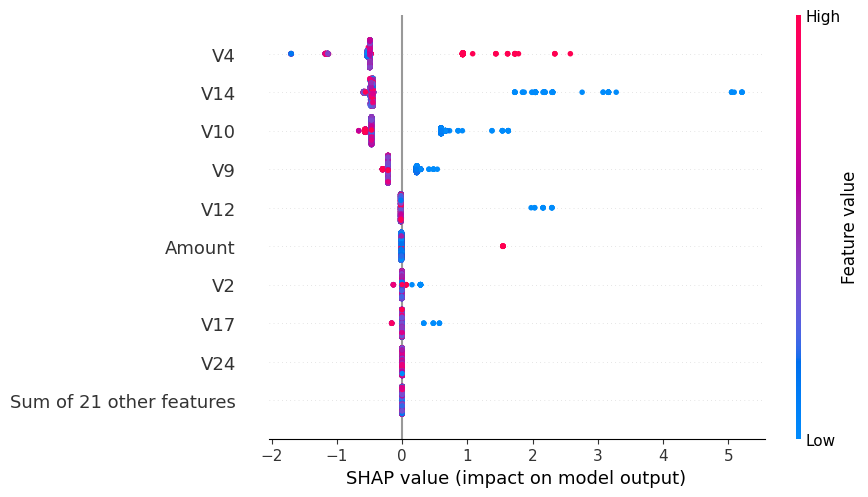

In [20]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Plot
shap.plots.beeswarm(shap_values)


In [21]:
import joblib

joblib.dump(rf, "rf_no_smote.pkl")
joblib.dump(xgb, "xgb_no_smote.pkl")
print(" Models saved: rf_no_smote.pkl, xgb_no_smote.pkl")


 Models saved: rf_no_smote.pkl, xgb_no_smote.pkl


In [22]:
#Load & Predict
loaded_xgb = joblib.load("xgb_no_smote.pkl")
print("Sample prediction (XGBoost):", loaded_xgb.predict(X_test[:1]))


Sample prediction (XGBoost): [0]


In [23]:
#1. Get a sample input from the dataset
# Pick a random test sample
sample = X_test.iloc[0]
print(" Sample input:\n", sample)

# Reshape for prediction
sample_reshaped = sample.values.reshape(1, -1)


 Sample input:
 Time     -0.539938
V1        1.216709
V2        0.405113
V3        0.452752
V4        0.767846
V5       -0.452447
V6       -1.233331
V7        0.171785
V8       -0.282427
V9       -0.138492
V10      -0.315961
V11       0.391667
V12       0.861307
V13       1.145248
V14      -0.459923
V15       0.964302
V16       0.338968
V17       0.057736
V18      -0.523245
V19      -0.330656
V20      -0.010563
V21      -0.249532
V22      -0.694827
V23       0.150009
V24       0.698647
V25       0.202298
V26       0.069985
V27      -0.017971
V28       0.037785
Amount   -0.390673
Name: 2994, dtype: float64


In [24]:
#2. Predict using the trained XGBoost model
# Predict with trained model
prediction = xgb.predict(sample_reshaped)
prediction_proba = xgb.predict_proba(sample_reshaped)

print("\n Prediction:", "Fraud" if prediction[0] == 1 else "Genuine")
print(" Probability:", prediction_proba[0])



 Prediction: Genuine
 Probability: [9.9991888e-01 8.1114005e-05]
